# <center> Real phantom: splines </center>

In this paper we will develope an imaging techinque, to generate realistic phantom based on regions of interest with piecewise smooth boundary, using splines as the smooth boundary pieces. 

In [1388]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [1389]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [1390]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cv2
import math
import cmocean

In [1391]:
def _fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels
    and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()

    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)

    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel
    # to have it in RGBA mode
    buf = np.roll(buf, 3, axis=2)
    return buf

## Ellipses

In [1392]:
from ellipse.ellipseWF_factory import WFupdate,Wavefrontset_ellipse_classes, plot_WF

In [1393]:
def _ellipse_gen(center, width, height, angle, size, opacity=1):
    """Function that generates the data of the ellipse
    """
    # Generate the Ellipse figure
    fig = plt.figure(0, frameon=False, figsize=(1, 1), dpi=size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    e = Ellipse([center[0],size-center[1]], width, height, angle)
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(None)
    e.set_facecolor(np.zeros(3))
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    fig.add_axes(ax)
    plt.axis('off')
    # Convert figure to data
    data = _fig2data(fig)
    plt.close(fig)
    # Take just the first color entry
    data = data[:, :, 1]
    # Normalize the data
    data = data/data.max()
    # data = np.flip(data, 0)
    return ((data-1)*opacity)+1

In [1394]:
def _ellipse_grad_gen(center, width, height, angle, size, opacity, grad_level):
    """Function that generates the data of the ellipse with color gradient
    """
    # Compute the needed parameters
    h,k = center[0],center[1]
    a,b = width/2, height/2
    theta = -math.radians(angle)
    # Precalculate constants
    st, ct =  math.sin(theta), math.cos(theta)
    aa, bb = a**2, b**2

    # Generate (x,y) coordinate arrays
    y,x = np.mgrid[-k:size-k,-h:size-h]
    # Calculate the weight for each pixel
    ellipse = (((x * ct + y * st) ** 2) / aa) + (((x * st - y * ct) ** 2) / bb)
    ellipse = np.clip(1.0 - ellipse, 0,grad_level)*opacity/grad_level
    return 1-ellipse

In [2154]:
def _center_origin_gen(size):
    return [rnd.randint(low=0+int(size/10), high=size-int(size/10)),
            rnd.randint(low=0+int(size/10), high=size-int(size/10))]


def _width_height_side_gen(size):
    return [rnd.randint(low=10, high=int(size/3)),
            rnd.randint(low=10, high=int(size/3))]


def _angle_gen():
    return rnd.randint(low=0, high=180)


def _opacity_gen():
    return rnd.uniform(0.2, 1.0)


def _ellipses_parameters(size,dirBias):
    # Random parameters for the ellipse
    center = _center_origin_gen(size)
    width, height = _width_height_side_gen(size)
    angle = _angle_gen()
    opacity = _opacity_gen()
    return center, width, height, angle, opacity

In [2155]:
def random_ellipse(size, nEllipses, dirBias, nClasses):
    """Create a `size` x `size` image with `nEllipses` phantom with random
    ellipses

    Parameters
    -----------
    size : integer, size of image

    nEllipses : integer, the number of ellipses in the image

    dirBias : integer, the center angle of the directional bias

        Returns
    -----------
    phantom : numpy array, `size` x `size` image with `nEllipses`
         phantom with random ellipses
    """
    # Create the WFimage, WFpoints and WF_classes
    WFimage = np.zeros((size,size))
    WFpoints_all = []
    WFclasses_all = []
    ellipses = np.zeros((size,size))
    
    # Big ellipses
    for i in range(nEllipses):
        center, width, height, angle, opacity = _ellipses_parameters(size,dirBias)
        grad_level = rnd.uniform(-2,2)
        if grad_level <= 0:
            ellipses += _ellipse_gen(center, width, height, angle, size, opacity)
        else:
            ellipses += _ellipse_grad_gen(center, width, height, angle, size, opacity, grad_level)
        # Update WFimage
        WFpoints, WFclasses = Wavefrontset_ellipse_classes(center, width, height, angle, nClasses)
        
        keep_index = (WFpoints[:,0] < size)*(WFpoints[:,1] < size) 
        WFclasses = list(np.array(WFclasses)[keep_index])
        WFpoints = WFpoints[keep_index] 
        
        
        WFpoints_all += list(WFpoints)
        WFclasses_all += list(WFclasses)
        WFimage = WFupdate(WFpoints, WFclasses, WFimage)

    # Sum the hull and the inner ellipses and normalize
    ellipses = 1 - ellipses/ellipses.max()
    ellipses = np.interp(ellipses, (ellipses.min(), ellipses.max()), (0, 1))

    return ellipses, np.array(WFpoints_all), WFclasses_all, WFimage

In [2156]:
size = 256;
nEllipses = 1;
dirBias = 60;
nClasses = 180;

In [2157]:
center, width, height, angle, opacity = _ellipses_parameters(size,dirBias)
grad_level = rnd.uniform(-2,2)

In [2158]:
ellipse = _ellipse_gen(center, width, height, angle, size, opacity);
ellipse_grad = _ellipse_grad_gen(center, width, height, angle, size, opacity, grad_level);

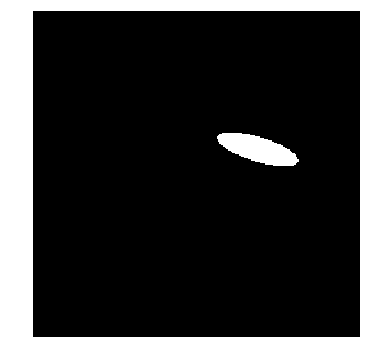

In [2159]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(1-ellipse, cmap="gray")

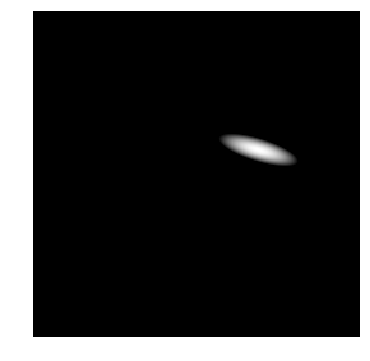

In [2160]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(1-ellipse_grad, cmap="gray")

In [2161]:
ellipse, WFpoints, WFclasses, WFimage = random_ellipse(size, nEllipses, dirBias, nClasses);

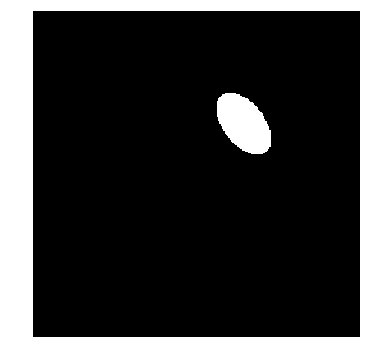

In [2162]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(ellipse, cmap="gray")

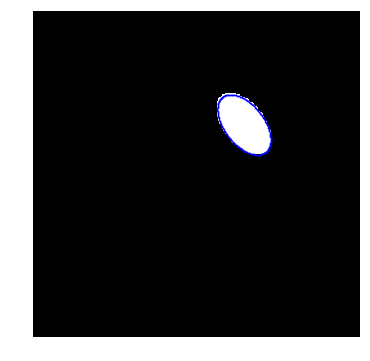

In [2165]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(ellipse, cmap = 'gray')
plt.plot(WFpoints[:,0], WFpoints[:,1], 'bo', markersize = 0.5)

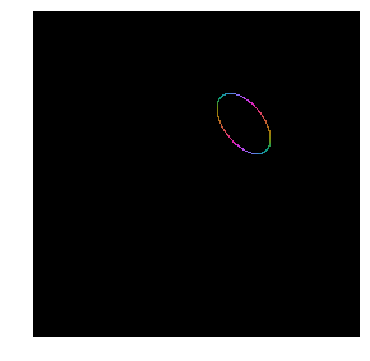

In [2164]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

## Spline boundary

In [2171]:
import matplotlib.patches as patches

### Generate set of points

In [2836]:
size = 256
nedges = 4
r = .7 # magnitude of the perturbation from the unit circle, 
center = [128,128]
scale = 20

In [2837]:
# Number of points
N = nedges*3+1
angles = np.linspace(0,2*np.pi,N)

In [2838]:
verts = np.stack((np.cos(angles),np.sin(angles))).T*(2*r*np.random.random(N)+1-r)[:,None]
verts[-1,:] = verts[0,:]

In [2839]:
# rescaling and translating vertices
verts = scale*verts;
verts = verts+center;

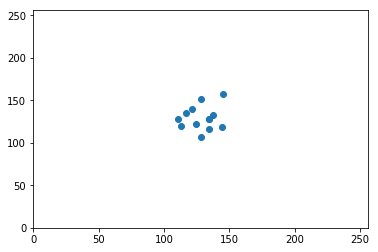

In [2840]:
fig = plt.figure(0)
ax = fig.add_subplot(111)
patch.set_clip_box(ax.bbox)
patch.set_alpha(None)
patch.set_facecolor(np.zeros(3))

ax.set_xlim(0, size)
ax.set_ylim(0, size)
fig.add_axes(ax)
plt.plot(verts[:,0],verts[:,-1], "o")

## Linear spline first segment

In [2841]:
i = 0
x1 = verts[i,:]
x2 = verts[i+1,:]

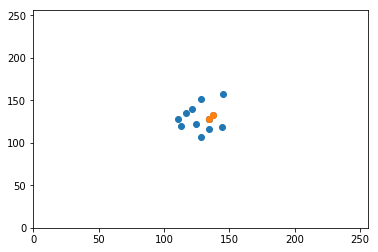

In [2842]:
fig = plt.figure(0)
ax = fig.add_subplot(111)
patch.set_clip_box(ax.bbox)
patch.set_alpha(None)
patch.set_facecolor(np.zeros(3))

ax.set_xlim(0, size)
ax.set_ylim(0, size)
fig.add_axes(ax)
plt.plot(verts[:,0],verts[:,-1], "o", [x1[0],x2[0]],[x1[1],x2[1]],"o")

In [2843]:
indices = np.argsort([x1[0], x2[0]])
XY = np.concatenate((x1[np.newaxis,:],x2[np.newaxis,:]))[indices,:]
x = XY[:,0]
y = XY[:,1]

In [2844]:
import scipy.interpolate as interpolate

In [2845]:
S = interpolate.UnivariateSpline(x, y, k=1)

In [2846]:
xnew = np.linspace(x[0], x[-1], num=int((x[-1]-x[0])), endpoint=True)
ynew = S(xnew)

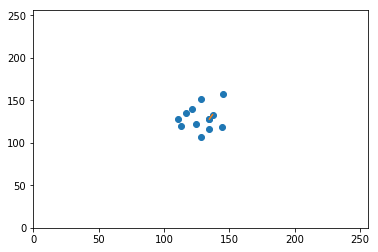

In [2847]:
fig = plt.figure(0)
ax = fig.add_subplot(111)
patch.set_clip_box(ax.bbox)
patch.set_alpha(None)
patch.set_facecolor(np.zeros(3))

ax.set_xlim(0, size)
ax.set_ylim(0, size)
fig.add_axes(ax)
plt.plot(verts[:,0],verts[:,-1], "o", xnew, ynew, "-")

In [2848]:
WFimage = np.zeros((size,size))
WFpoints_all = []
WFclasses_all = []

In [2849]:
WFpoints = np.zeros((xnew.shape[0],2));
WFpoints[:,0] = xnew;
WFpoints[:,1] = ynew;

In [2850]:
# Computing the classes
WFclasses = [np.array([(np.arctan(S.derivative(n=1)(xi))
              *180/(np.pi)+90)%180+1]) for xi in xnew];

In [2851]:
keep_index = (WFpoints[:,0] < size)*(WFpoints[:,1] < size) 
WFclasses = list(np.array(WFclasses)[keep_index])
WFpoints = WFpoints[keep_index]

In [2852]:
if indices[0] == 1:
    WFpoints = np.flip(WFpoints, axis=0)
    WFclasses.reverse()

In [2853]:
WFpoints_all+=list(WFpoints)
WFclasses_all += WFclasses

In [2854]:
WFimage = np.zeros((size,size))
WFimage = WFupdate(WFpoints, WFclasses, WFimage)

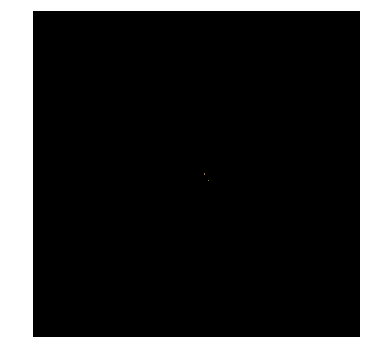

In [2855]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

## Quadratic spline

In [2856]:
i = 1
x1 = verts[i,:]
x2 = verts[i+1,:]
x3 = verts[i+2,:]

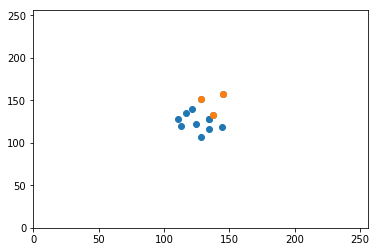

In [2857]:
fig = plt.figure(0)
ax = fig.add_subplot(111)
patch.set_clip_box(ax.bbox)
patch.set_alpha(None)
patch.set_facecolor(np.zeros(3))

ax.set_xlim(0, size)
ax.set_ylim(0, size)
fig.add_axes(ax)
plt.plot(verts[:,0],verts[:,-1], "o", [x1[0],x2[0], x3[0]],[x1[1],x2[1],x3[1]],"o")

In [2858]:
indices = np.argsort([x1[0], x2[0], x3[0]])
XY = np.concatenate((x1[np.newaxis,:],x2[np.newaxis,:],x3[np.newaxis,:] ))[indices,:]
x = XY[:,0]
y = XY[:,1]

In [2859]:
S = interpolate.UnivariateSpline(x, y, k=2)

In [2860]:
xnew = np.linspace(x[0], x[-1], num=int((x[-1]-x[0])), endpoint=True)
ynew = S(xnew)

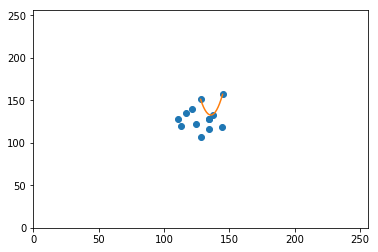

In [2861]:
fig = plt.figure(0)
ax = fig.add_subplot(111)
patch.set_clip_box(ax.bbox)
patch.set_alpha(None)
patch.set_facecolor(np.zeros(3))

ax.set_xlim(0, size)
ax.set_ylim(0, size)
fig.add_axes(ax)
plt.plot(verts[:,0],verts[:,-1], "o", xnew, ynew, "-")

In [2862]:
WFpoints = np.zeros((xnew.shape[0],2));
WFpoints[:,0] = xnew;
WFpoints[:,1] = ynew;

In [2863]:
# Computing the classes
WFclasses = [np.array([(np.arctan(S.derivative(n=1)(xi))
              *180/(np.pi)+90)%180+1]) for xi in xnew];

In [2864]:
keep_index = (WFpoints[:,0] < size)*(WFpoints[:,1] < size) 
WFclasses = list(np.array(WFclasses)[keep_index])
WFpoints = WFpoints[keep_index]

In [2865]:
if indices[0] == 1:
    WFpoints = np.flip(WFpoints, axis=0)
    WFclasses.reverse()

In [2866]:
WFpoints_all+=list(WFpoints)
WFclasses_all += WFclasses

In [2867]:
WFimage = np.zeros((size,size))
WFimage = WFupdate(WFpoints, WFclasses, WFimage)

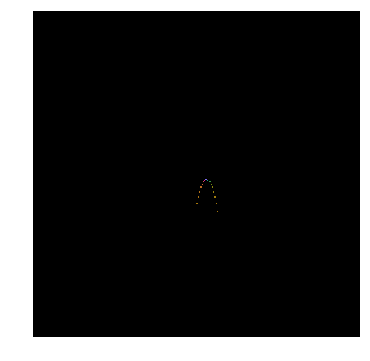

In [2868]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

## Cubic spline

In [2869]:
i = 3
x1 = verts[i,:]
x2 = verts[i+1,:]
x3 = verts[i+2,:]
x4 = verts[i+3,:]

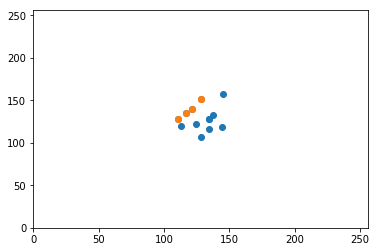

In [2870]:
fig = plt.figure(0)
ax = fig.add_subplot(111)
patch.set_clip_box(ax.bbox)
patch.set_alpha(None)
patch.set_facecolor(np.zeros(3))

ax.set_xlim(0, size)
ax.set_ylim(0, size)
fig.add_axes(ax)
plt.plot(verts[:,0],verts[:,-1], "o", [x1[0],x2[0], x3[0], x4[0]],[x1[1],x2[1],x3[1], x4[1]],"o")

In [2871]:
indices = np.argsort([x1[0], x2[0], x3[0], x4[0]])
XY = np.concatenate((x1[np.newaxis,:],x2[np.newaxis,:],x3[np.newaxis,:],x4[np.newaxis,:]))[indices,:]
x = XY[:,0]
y = XY[:,1]

In [2872]:
S = interpolate.UnivariateSpline(x, y, k=3)

In [2873]:
xnew = np.linspace(x[0], x[-1], num=int((x[-1]-x[0])), endpoint=True)
ynew = S(xnew)

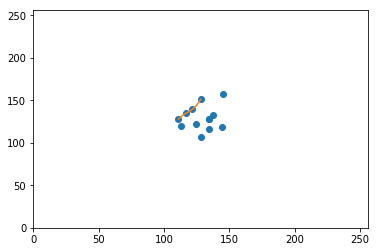

In [2874]:
fig = plt.figure(0)
ax = fig.add_subplot(111)
patch.set_clip_box(ax.bbox)
patch.set_alpha(None)
patch.set_facecolor(np.zeros(3))

ax.set_xlim(0, size)
ax.set_ylim(0, size)
fig.add_axes(ax)
plt.plot(verts[:,0],verts[:,-1], "o", xnew, ynew, "-")

In [2875]:
WFpoints = np.zeros((xnew.shape[0],2));
WFpoints[:,0] = xnew;
WFpoints[:,1] = ynew;

In [2876]:
# Computing the classes
WFclasses = [np.array([(np.arctan(S.derivative(n=1)(xi))
              *180/(np.pi)+90)%180+1]) for xi in xnew];

In [2877]:
keep_index = (WFpoints[:,0] < size)*(WFpoints[:,1] < size) 
WFclasses = list(np.array(WFclasses)[keep_index])
WFpoints = WFpoints[keep_index]

In [2878]:
if indices[0] == 1:
    WFpoints = np.flip(WFpoints, axis=0)
    WFclasses.reverse()

In [2879]:
WFpoints_all+=list(WFpoints)
WFclasses_all += WFclasses

In [2880]:
WFimage = np.zeros((size,size))
WFimage = WFupdate(WFpoints, WFclasses, WFimage)

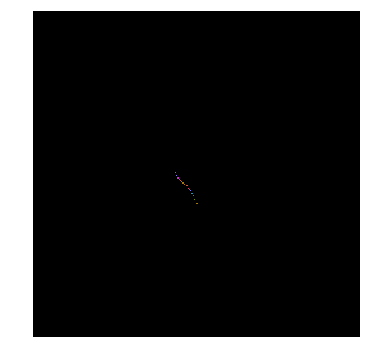

In [2881]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

## Wavefront set total

In [2882]:
WFpoints_all = np.array(WFpoints_all)

In [2229]:
WFimage = np.zeros((size,size))
WFimage = WFupdate(WFpoints_all, WFclasses_all, WFimage)
WFimage = WFimage

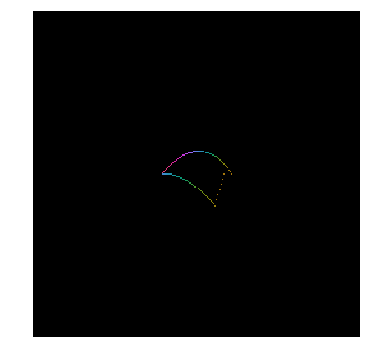

In [2230]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

## Spline image generation

In [2478]:
from matplotlib.path import Path
import matplotlib.patches as patches

In [2479]:
patch = plt.Polygon([[WFpoints_all[i,0], WFpoints_all[i,1]] for i in range(len(WFpoints_all))])

In [2480]:
plt.close(fig)

In [2481]:
opacity = 0.5

In [2482]:
fig = plt.figure(0, frameon=False, figsize=(1, 1), dpi=size)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
ax.add_patch(patch)
patch.set_clip_box(ax.bbox)
patch.set_alpha(None)
patch.set_facecolor(np.zeros(3))

ax.set_xlim(0, size)
ax.set_ylim(0, size)
fig.add_axes(ax)
plt.axis('off')

plt.close(fig)
# Convert figure to data
phantom = _fig2data(fig)
plt.close(fig)
# Take just the first color entry
phantom = np.flip(phantom[:, :, 1], axis=0)
# Normalize the data
phantom = phantom/phantom.max();
phantom = 1-(((phantom-1)*opacity)+1)

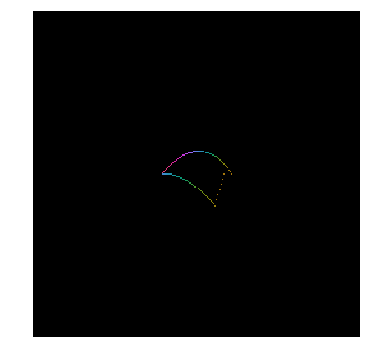

In [2483]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

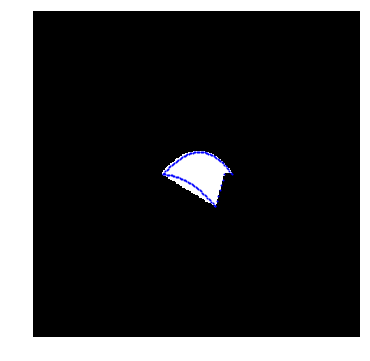

In [2484]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(phantom, cmap = 'gray')
plt.plot(WFpoints_all[:,0], WFpoints_all[:,1], 'bo', markersize = 1)

## Adding gradient to phantom

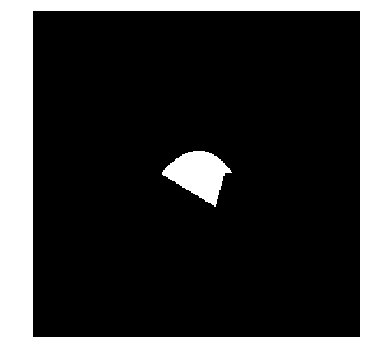

In [2620]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(phantom, cmap = "gray")

In [2883]:
grad_level = 2

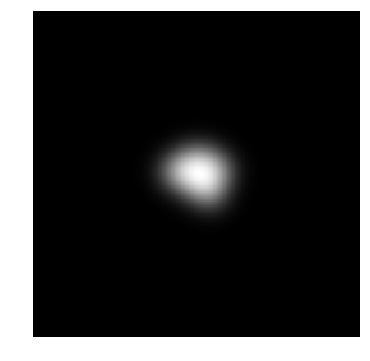

In [2884]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(gaussian_filter(phantom, sigma = 5*grad_level),cmap = "gray")